Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 2

#### Objectives
- log-transform regression target with right-skewed distribution
- Understand why accuracy is a misleading metric when classes are imbalanced
- Use classification metric: ROC AUC
- Visualize the ROC curve by plotting true positive rate vs false positive rate at varying thresholds
- Use the class_weight parameter in scikit-learn

### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python package, if you haven't already:

[category_encoders](http://contrib.scikit-learn.org/categorical-encoding/), version >= 2.0  

`conda install -c conda-forge category_encoders`

or

`pip install --upgrade category_encoders`

In [ ]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python package:
    # category_encoders, version >= 2.0
    !pip install --upgrade category_encoders
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module2')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling
 * branch            master     -> FETCH_HEAD
Already up to date.


# Log-transform regression target with right-skewed distribution

## Moore's Law dataset

#### Background
- https://en.wikipedia.org/wiki/Moore%27s_law
- https://en.wikipedia.org/wiki/Transistor_count

#### Scrape HTML tables with Pandas!
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html
- https://medium.com/@ageitgey/quick-tip-the-easiest-way-to-grab-data-out-of-a-web-page-in-python-7153cecfca58

#### More web scraping options
- https://automatetheboringstuff.com/chapter11/

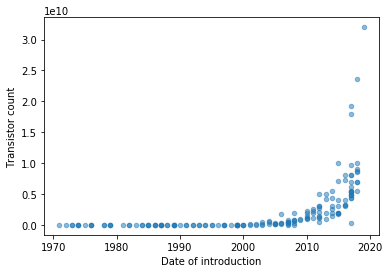

In [ ]:
# Scrape data
import pandas as pd
tables = pd.read_html('https://en.wikipedia.org/wiki/Transistor_count', header=0)
moore = tables[0]
moore = moore[['Date of introduction', 'Transistor count']].dropna()

# Clean data
for column in moore:
    moore[column] = (moore[column]
                     .str.split('[').str[0]  # Remove citations
                     .str.replace(r'\D','')  # Remove non-digit characters
                     .astype(float))
    
moore = moore.sort_values(by='Date of introduction')

# Plot relationship between date & transistors
%matplotlib inline
moore.plot(x='Date of introduction', y='Transistor count', 
           kind='scatter', alpha=0.5);

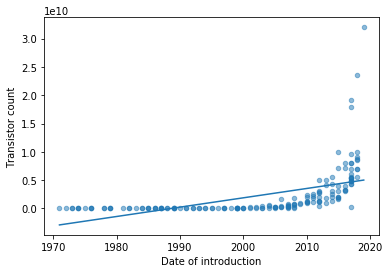

In [ ]:
# Fit Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = ['Date of introduction']
target = 'Transistor count'
X = moore[features]
y = moore[target]
model.fit(X, y)
y_pred = model.predict(X)

# Plot line of best fit
ax = moore.plot(x='Date of introduction', y='Transistor count', kind='scatter', alpha=0.5)
ax.plot(X, y_pred);

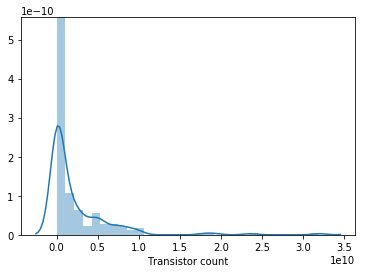

In [ ]:
# Plot distribution of transistor counts
import seaborn as sns
y = moore['Transistor count']
sns.distplot(y);

In [ ]:
# Describe distribution of transistor counts
pd.options.display.float_format = '{:,.0f}'.format
y.describe()

count              165
mean     2,272,467,558
std      4,264,832,162
min              2,300
25%          1,000,000
50%        362,000,000
75%      3,000,000,000
max     32,000,000,000
Name: Transistor count, dtype: float64

In [ ]:
# Log-transform the target
import numpy as np
y_log = np.log1p(y)
moore['log(Transistor count)'] = y_log

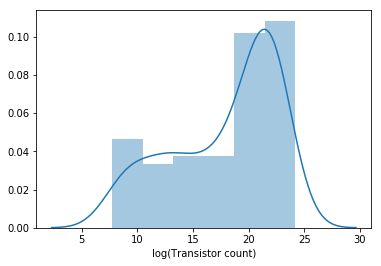

In [ ]:
# Plot distribution of log-transformed target
sns.distplot(moore['log(Transistor count)']);

In [ ]:
# Describe distribution of log-transformed target
y_log.describe()

count   165
mean     18
std       5
min       8
25%      14
50%      20
75%      22
max      24
Name: Transistor count, dtype: float64

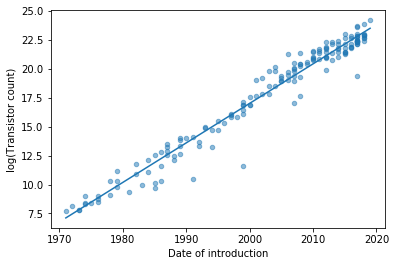

In [ ]:
# Fit Linear Regression with log-transformed target
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = ['Date of introduction']
target = 'log(Transistor count)'
X = moore[features]
y_log = moore[target]
model.fit(X, y_log)
y_pred_log = model.predict(X)

# Plot line of best fit, in units of log-transistors
ax = moore.plot(x='Date of introduction', y='log(Transistor count)', kind='scatter', alpha=0.5)
ax.plot(X, y_pred_log);

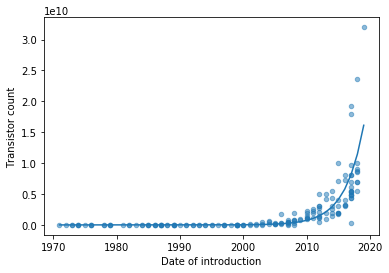

In [ ]:
# Convert log-transistors to transistors
y_pred = np.expm1(y_pred_log)

# Plot line of best fit, in units of transistors
ax = moore.plot(x='Date of introduction', y='Transistor count', kind='scatter', alpha=0.5)
ax.plot(X, y_pred);

#### Terence Parr & Jeremy Howard, [The Mechanics of Machine Learning, Chapter 5.5](https://mlbook.explained.ai/prep.html#logtarget)

> Transforming the target variable (using the mathematical log function) into a tighter, more uniform space makes life easier for any model.

> The only problem is that, while easy to execute, understanding why taking the log of the target variable works and how it affects the training/testing process is intellectually challenging. You can skip this section for now, if you like, but just remember that this technique exists and check back here if needed in the future.

> Optimally, the distribution of prices would be a narrow “bell curve” distribution without a tail. This would make predictions based upon average prices more accurate. We need a mathematical operation that transforms the widely-distributed target prices into a new space. The “price in dollars space” has a long right tail because of outliers and we want to squeeze that space into a new space that is normally distributed (“bell curved”). More specifically, we need to shrink large values a lot and smaller values a little. That magic operation is called the logarithm or log for short. 

> To make actual predictions, we have to take the exp of model predictions to get prices in dollars instead of log dollars.

#### Wikipedia, [Logarithm](https://en.wikipedia.org/wiki/Logarithm)

> Addition, multiplication, and exponentiation are three fundamental arithmetic operations. Addition can be undone by subtraction. Multiplication can be undone by division. The idea and purpose of **logarithms** is also to **undo** a fundamental arithmetic operation, namely raising a number to a certain power, an operation also known as **exponentiation.** 

> For example, raising 2 to the third power yields 8.

> The logarithm (with respect to base 2) of 8 is 3, reflecting the fact that 2 was raised to the third power to get 8.

### Use Numpy for exponents and logarithms functions
- https://docs.scipy.org/doc/numpy/reference/routines.math.html#exponents-and-logarithms

In [ ]:
2 ** 3

8

In [ ]:
np.log2(8)

3.0

In [ ]:
np.e ** 42

1.7392749415204972e+18

In [ ]:
np.log(1.7392749415204972e+18)

42.0

In [ ]:
np.log(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [ ]:
np.log1p(0)

0.0

In [ ]:
np.log1p(42)

3.7612001156935624

In [ ]:
np.expm1(3.7612001156935624)

42.0

# Shift to CLASSIFICATION

## Lending Club 🏦

This lecture uses Lending Club data, historical and current. Predict if peer-to-peer loans are charged off or fully paid. Decide which loans to invest in.

#### Background

[According to Wikipedia,](https://en.wikipedia.org/wiki/Lending_Club)

> Lending Club is the world's largest peer-to-peer lending platform. Lending Club enables borrowers to create unsecured personal loans between \\$1,000 and \\$40,000. The standard loan period is three years. **Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose.** Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

Lending Club's article about [Benefits of diversification](https://www.lendingclub.com/investing/investor-education/benefits-of-diversification) explains,

> **With the investment minimum of \\$1,000, you can get up to 40 Notes at \$25 each.**

You can read more good context in [Data-Driven Investment Strategies for Peer-to-Peer Lending: A Case Study for Teaching Data Science](https://www.liebertpub.com/doi/full/10.1089/big.2018.0092):

> Current refers to a loan that is still being reimbursed in a timely manner. Late corresponds to a loan on which a payment is between 16 and 120 days overdue. If the payment is delayed by more than 121 days, the loan is considered to be in Default. If LendingClub has decided that the loan will not be paid off, then it is given the status of Charged-Off.

> These dynamics imply that 5 months after the term of each loan has ended, every loan ends in one of two LendingClub states—fully paid or charged-off. We call these two statuses fully paid and defaulted, respectively, and we refer to a loan that has reached one of these statuses as expired. **One way to simplify the problem is to consider only loans that have expired at the time of analysis.**

> A significant portion (13.5%) of loans ended in Default status; depending on how much of the loan was paid back, these loans
might have resulted in a significant loss to investors who had invested in them. The remainder was Fully Paid—the borrower fully reimbursed the loan’s outstanding balance with interest, and the investor earned a positive return on his or her investment. Therefore, to avoid unsuccessful investments, **our goal is to estimate which loans are more likely to default and which will yield low returns.**

In [ ]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

history_location = '../data/lending-club/lending-club-subset.csv'
current_location = '../data/lending-club/primaryMarketNotes_browseNotes_1-RETAIL.csv'

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

### Wrangle data
- Engineer date-based features
- Remove features to avoid leakage
- Do 3-way split, train/validate/test

In [ ]:
# Engineer date-based features

# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [ ]:
# Use Python sets to compare the historical columns & current columns

common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [ ]:
# Train on the historical data.
# For features, use only the common columns shared by the historical & current data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')

features = list(common_columns)
target = 'loan_status'
X = history[features]
y = history[target]

In [ ]:
# Do train/validate/test 3-way split

from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 108)
y_train shape (88334,)
X_val shape (20000, 108)
y_val shape (20000,)
X_test shape (20000, 108)
y_test shape (20000,)


## Understand why accuracy is a misleading metric when classes are imbalanced

### Get accuracy score for majority class baseline

In [ ]:
pd.options.display.float_format = None

In [ ]:
y_train.value_counts(normalize=True)

Fully Paid     0.824858
Charged Off    0.175142
Name: loan_status, dtype: float64

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.82485

### Get confusion matrix for majority class baseline

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

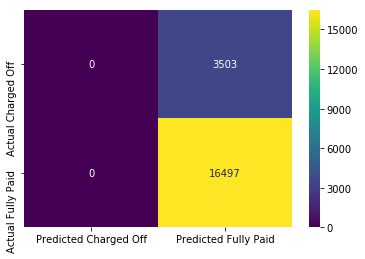

In [ ]:
plot_confusion_matrix(y_val, y_pred);

### Get precision & recall for majority class baseline

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00      3503
  Fully Paid       0.82      1.00      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.82      0.75     20000



### Get ROC AUC score for majority class baseline
[sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

In [ ]:
from sklearn.metrics import roc_auc_score

# What if we predicted 100% probability of the positive class for every prediction?
# This is like the majority class baseline, but with predicted probabilities,
# instead of just discrete classes.
# VERY IMPORTANT — Use predicted probabilities with ROC AUC score!
# Because, it's a metric of how well you rank/sort predicted probabilities.
y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

0.5

In [ ]:
# ROC AUC is 0.50 by definition when predicting any constant probability value
y_pred_proba = np.full_like(y_val, fill_value=0)
roc_auc_score(y_val, y_pred_proba)

0.5

In [ ]:
y_pred_proba = np.full_like(y_val, fill_value=0.50)
roc_auc_score(y_val, y_pred_proba)

0.5

In [ ]:
y_val.value_counts()

Fully Paid     16497
Charged Off     3503
Name: loan_status, dtype: int64

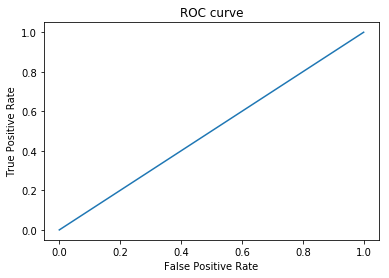

In [ ]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val=='Charged Off', y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

### Fit a model

#### Count missing values

In [ ]:
null_counts = X_train.isnull().sum().sort_values(ascending=False)
null_counts.reset_index()

In [ ]:
many_nulls = null_counts[:73].index
print(list(many_nulls))

['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_inq_last_6mths', 'revol_bal_joint', 'sec_app_mort_acc', 'sec_app_collections_12_mths_ex_med', 'sec_app_open_act_il', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_fico_range_low', 'sec_app_chargeoff_within_12_mths', 'dti_joint', 'annual_inc_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 'mths_since_rcnt_il', 'all_util', 'total_cu_tl', 'open_rv_24m', 'open_il_12m', 'open_il_24m', 'open_acc_6m', 'open_rv_12m', 'max_bal_bc', 'open_act_il', 'inq_fi', 'total_bal_il', 'inq_last_12m', 'mths_since_last_delinq', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 'avg_cur_bal', 'num_rev_accts', 'num_il_tl', 'num_tl_90g_dpd_24m', 'total_il_high_credit_limit', 'num_bc_tl', 'num_actv_rev_tl', 'tot

#### Wrangle data

In [ ]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

In [ ]:
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train);

CPU times: user 1min 14s, sys: 378 ms, total: 1min 14s
Wall time: 39.3 s


### Get accuracy score for model

In [ ]:
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

0.82555

### Get confusion matrix for model

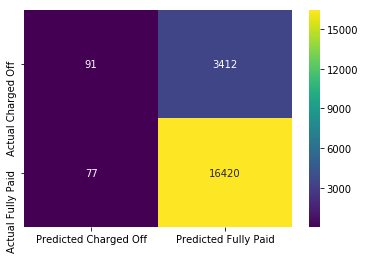

In [ ]:
plot_confusion_matrix(y_val, y_pred);

### Get precision & recall for model

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.54      0.03      0.05      3503
  Fully Paid       0.83      1.00      0.90     16497

    accuracy                           0.83     20000
   macro avg       0.68      0.51      0.48     20000
weighted avg       0.78      0.83      0.75     20000



### Get ROC AUC score for model

In [ ]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.692567006404386

## Understand ROC AUC (Receiver Operating Characteristic, Area Under the Curve)

#### Scikit-Learn docs
- [User Guide: Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

#### More links
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings."

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures how well a classifier ranks predicted probabilities. It ranges from 0 to 1. A naive majority class baseline will have an ROC AUC score of 0.5. 

## Visualize the ROC curve by plotting true positive rate vs false positive rate at varying thresholds

In [ ]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    # Show confusion matrix & classification report
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

### Use the class_weight parameter in scikit-learn

Here's a fun demo you can explore! The next code cells do five things:

#### 1. Generate data

We use scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to generate fake data for a binary classification problem, based on several parameters, including:
- Number of samples
- Weights, meaning "the proportions of samples assigned to each class."
- Class separation: "Larger values spread out the clusters/classes and make the classification task easier."

(We are generating fake data so it is easy to visualize.)

#### 2. Split data

We split the data three ways, into train, validation, and test sets. (For this toy example, it's not really necessary to do a three-way split. A two-way split, or even no split, would be ok. But I'm trying to demonstrate good habits, even in toy examples, to avoid confusion.)

#### 3. Fit model

We use scikit-learn to fit a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the training data.

We use this model parameter:

> **class_weight : _dict or ‘balanced’, default: None_**

> Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.


#### 4. Evaluate model

We use our Logistic Regression model, which was fit on the training data, to generate predictions for the validation data.

Then we print [scikit-learn's Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report), with many metrics, and also the accuracy score. We are comparing the correct labels to the Logistic Regression's predicted labels, for the validation set. 

#### 5. Visualize decision function

Based on these examples
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-1-decision-regions-in-2d

In [ ]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

              precision    recall  f1-score   support

           0       1.00      0.15      0.25        96
           1       0.05      1.00      0.09         4

    accuracy                           0.18       100
   macro avg       0.52      0.57      0.17       100
weighted avg       0.96      0.18      0.25       100



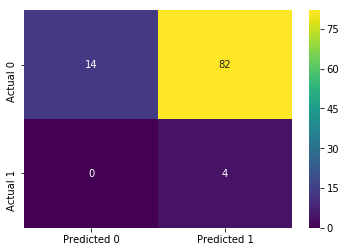

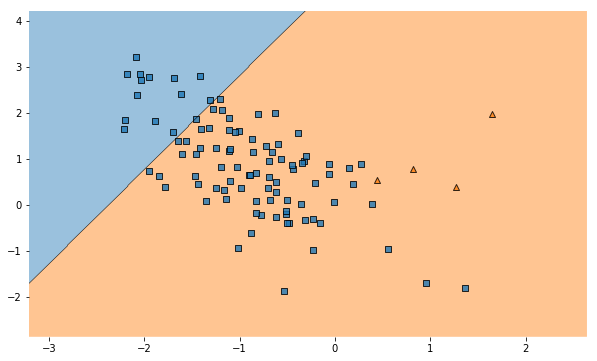

In [ ]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions


#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = {0: 1, 1: 10000}

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);

Try re-running the cell above with different values for these four parameters:
- `n_samples`
- `weights`
- `class_sep`
- `class_balance`

For example, with a 50% / 50% class distribution:
```
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8
class_balance = None
```

With a 95% / 5% class distribution:
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = None
```

With the same 95% / 5% class distribution, but changing the Logistic Regression's `class_balance` parameter to `'balanced'` (instead of its default `None`)
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = 'balanced'
```

With the same 95% / 5% class distribution, but with different values for `class_balance`:
- `{0: 1, 1: 1}` _(equivalent to `None`)_
- `{0: 1, 1: 2}`
- `{0: 1, 1: 10}` _(roughly equivalent to `'balanced'` for this dataset)_
- `{0: 1, 1: 100}`
- `{0: 1, 1: 10000}`

How do the evaluation metrics and decision region plots change?

## What you can do about imbalanced classes

[Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/) gives "a rough outline of useful approaches" : 

- Do nothing. Sometimes you get lucky and nothing needs to be done. You can train on the so-called natural (or stratified) distribution and sometimes it works without need for modification.
- Balance the training set in some way:
  - Oversample the minority class.
  - Undersample the majority class.
  - Synthesize new minority classes.
- Throw away minority examples and switch to an anomaly detection framework.
- At the algorithm level, or after it:
  - Adjust the class weight (misclassification costs).
  - Adjust the decision threshold.
  - Modify an existing algorithm to be more sensitive to rare classes.
- Construct an entirely new algorithm to perform well on imbalanced data.

#### We demonstrated two of these options: 

- "Adjust the class weight (misclassification costs)" — many scikit-learn classifiers have a `class_balance` parameter
- "Adjust the decision threshold" — you can lean more about this in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

#### Another option to be aware of:
- The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."